# Dependencies
We need to install tensorflow 2.7.0 to be compatible with quantum tensorflow

In [1]:
#!pip install -q tensorflow==2.7.0

#!pip install -q tensorflow-quantum

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
from collections import deque
from random import sample
from functools import reduce
import sys

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2022-11-29 16:56:57.862293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 16:56:57.862330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 16:57:19.619082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-29 16:57:19.619133: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 16:57:19.619162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marshalls-VB): /proc/driver/nvidia/version does not exist
2022-11-29 16:57:19.621090: I tensorflow/core/platform/cpu_featu

This array specifies hyper-parameters of the training run.
For the paper these are set in the command line, but for this notebook we hard code them to some demonstration values.


In [9]:
#L,k, number of epochs of training, number of training data
L = 5
k = 2
epochs = 10
n_training = 100
random_seed = 69
arguments_passed= [L, k, epochs, n_training, random_seed]

# Define model

This section will define the partitioned model that we will use.

The first 3 cells define "circuit generation", generating the ansatz we will use

## circuit generation

We will borrow heavily from the code of Sofiene and Andrea

We define a circuit by specifying the number of layers it needs to have, adding a controlled X on the first qubit, and a controlled Z on the last qubit, for every layer

In [4]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns a Cirq circuit that applies a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    yield cirq.rx(symbols[0])(qubit)
    yield cirq.ry(symbols[1])(qubit)
    yield cirq.rz(symbols[2])(qubit)

def entangling_layer(qubits, part_of_hadamard_test=True):
    """
    Returns a Cirq circuit that applies a layer of entangling gates (arranged in a circular topology).
    """
    if len(qubits) == 2:
        yield cirq.Circuit(cirq.CZ(qubits[0], qubits[1]))
    else:
        yield cirq.Circuit(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]) for i in range(len(qubits)))

def Cone_qubit_rotation(control, qubit, symbols):
    """
    Returns a Cirq circuit that applies a ortation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`. 

    We now use a controlled rotation, where the control qubit is the first qubit in the circuit. This is useful for the hadamard test.
    """
    yield cirq.rx(symbols[0])(qubit).controlled_by(control)
    yield cirq.ry(symbols[1])(qubit).controlled_by(control)
    yield cirq.rz(symbols[2])(qubit).controlled_by(control)

The following function creates the full circuit with a control on the first qubit

In [5]:
def gen_cont_circ(qubits,n_layers, real=True):
  """gens a controlled circuit, but half is controlled by the last qubit to replicate off diag terms"""
  #circuit width
  n = len(qubits) - 1
  control_qubit = qubits[n] #last qubit is the control
  #generate weight set, 2x normal because double depth
  params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n})')
  params = np.asarray(params).reshape(((n_layers + 1), n, 3))

  bravyi_params = sympy.symbols(f'zeta(0:{2*2*(n_layers)})')
  bravyi_params = np.asarray(bravyi_params).reshape((2*n_layers, 2))

  # Sympy symbols for encoding angles
  inputs = sympy.symbols(f'x(0:{n})'+f'_(0:{n_layers})')
  inputs = np.asarray(inputs).reshape((n_layers, n))

  #apply first H
  circuit=cirq.Circuit(cirq.H(control_qubit))
  if not real: circuit+= cirq.S(control_qubit)

  #make controlled circuit 1:
  #circuit = cirq.Circuit()
  for l in range(n_layers):
    # Variational layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits[:-1]))
    circuit += entangling_layer(qubits[:-1])
    #bravyi ghost encoding things
    circuit += cirq.ZPowGate(exponent = bravyi_params[l, 0], global_shift=0)(qubits[0  ]).controlled_by(control_qubit) #the x or target qubit (on the first qubit)
    circuit += cirq.ZPowGate(exponent = bravyi_params[l, 1], global_shift=0)(qubits[n-1]).controlled_by(control_qubit)#The z or control qubit (goes on the last qubit)
    #need to swap which circuit we're applying (apply the 1 circuit)
    circuit+=cirq.Circuit(cirq.X(control_qubit))
    #other bravyi ghost encoding things
    circuit += cirq.ZPowGate(exponent = bravyi_params[l+n_layers, 0], global_shift=0)(qubits[ 0 ]).controlled_by(control_qubit)#The x or target qubit (on the first qubit)
    circuit += cirq.ZPowGate(exponent = bravyi_params[l+n_layers, 1], global_shift=0)(qubits[n-1]).controlled_by(control_qubit)#The z or control qubit (goes on the last qubit)
    #need to swap back
    circuit+=cirq.Circuit(cirq.X(control_qubit))

    # Encoding layer
    circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits[:-1]))

  circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits[:-1]))


  #reinvert and apply 2nd H gate
  #circuit+=cirq.Circuit(cirq.X(control_qubit))
  circuit+=cirq.Circuit(cirq.H(control_qubit))
  if not real: circuit+= cirq.S(control_qubit)
  return circuit, list(bravyi_params.flat),list(params.flat), list(inputs.flat)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


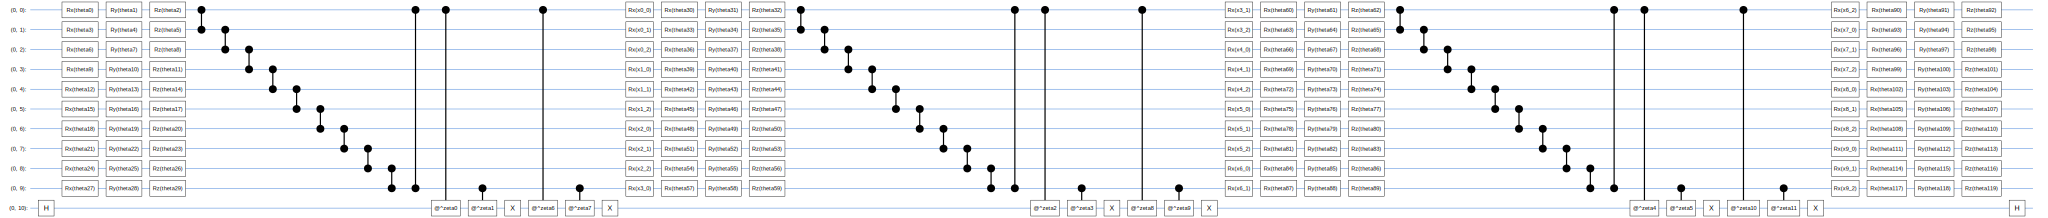

In [6]:
#test circuit
n_qubits, n_layers = 11, 3
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, bp, tp, ip = gen_cont_circ(qubits, n_layers, real = True)
SVGCircuit(circuit)

## Convert to a tensorflow model
taking the circuits generators from the previous model we can stitch the models together in a custom keras model.


In [7]:
class gen_comb_model(tf.keras.Model):
  """Generates the shit out of a model"""
  def __init__(self, n, d, K, L, input_dim = 5, trainable_regular_weights = True):
    """initalise, n is number of qubits in each PQC, d is the depth of the PQC
    K is the number of terms in the product, L is the number of terms in the sum"""
    super().__init__()
    self.n = n
    self.d = d
    self.K = K
    self.L = L
    self.size_of_split=n

    # qubits, observable, define circuit
    qubits = cirq.GridQubit.rect(1, self.n+1)
    ops = [cirq.Z(q) for q in qubits]
    observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3
    #define circuit and imaginary circuit,
    circuit, bravyi_params, theta_symbols, input_symbols  = gen_cont_circ(qubits, d)
    circuiti, _,              _,              _            = gen_cont_circ(qubits, d, real=False)
    #print(circuit)

    # define PQC weights and that shit
    #regular weights, the thetas
    theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
    self.theta = tf.Variable(
        initial_value=theta_init(shape=(1, len(theta_symbols)*K), dtype="float32"),
        trainable=trainable_regular_weights, name="thetas")
    self.individual_product_term_theta_size = len(theta_symbols)

    #weights to multiply by the training data, previously called lmbd in a move that wont be ridiculously confusing here.
    alphas_init = tf.ones(shape=(len(input_symbols)*K,))
    self.alphas = tf.Variable(
        initial_value=alphas_init, dtype="float32", trainable=trainable_regular_weights, name="alphas"
    )
    self.input_dim = len(input_symbols)*K

    #other shit
    self.activation = "linear"
    self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
    self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
    self.imag_computation_layer = tfq.layers.ControlledPQC(circuiti, observables)
    self.flatten = tf.keras.layers.Flatten(input_shape=(input_dim,input_dim))

    # define explicit order for symbols
    symbols = [str(symb) for symb in theta_symbols+input_symbols+bravyi_params ]
    self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
    
    # define zeta parameters
    zeta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
    self.zeta = tf.Variable(
        initial_value=zeta_init(shape=(L,K, len(bravyi_params)), dtype="float32"),
        trainable=True, name="zetas")
    
    # define lambdas
    rescale_parameter=1 #may need modifying later (lol)
    lambdas_init = tf.ones(shape=(L,))*rescale_parameter
    self.lambdas = tf.Variable(initial_value=lambdas_init, dtype="float32", trainable=True, name="lambdas")

  def giveZetas(self):
    return self.zeta

  def giveIndices(self):
    return self.indices

  def call(self, inputs):
    #lets keep it simple in this run, copy the circuit outputs for each different parameters, ew can put through multiple parameters at another time.
    #gather amount of data points
    batch_dim = tf.gather(tf.shape(inputs[0]), 0)
    #copy thetas and inputs for inputs
    tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
    inputs = [self.flatten(inputs[0])]
    tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.d])#need double the amount of input copies
    scaled_inputs = tf.einsum("i,ji->ji", self.alphas, tiled_up_inputs)# This needs to be worked in, we should apply alphas before dividing it
    squashed_inputs = tf.keras.layers.Activation(self.activation)(tiled_up_inputs)
    
    #hold hte circuit outputs for each input
    ans = tf.zeros([batch_dim, 1])
    for j in range(self.L):
      PQC_layer_ans = tf.complex(tf.ones([batch_dim, 1]),tf.zeros([batch_dim, 1]))#the complex number for the product part of the calculation
      for i in range(self.K):
        #rack up some circuits to use in the PQC
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_circuitsi= tf.repeat(self.empty_circuit, repeats=batch_dim) 

        #take the inputs for this circuit
        our_inputs =tf.slice(squashed_inputs, [0,i*self.n], [batch_dim, self.n*self.d])
        ####################################################################################################################################################HERE YOU MIGHT WANT TO CHANGE THE WAY WE PICK INPUTS, ITS IMPORTANT WE dont try and select parts of the input vector that dont exist
        
        # take the thetas we want
        our_thetas = tf.slice(tiled_up_thetas, [0,i*self.individual_product_term_theta_size], [batch_dim, self.individual_product_term_theta_size])
        
        #add in zetas
        our_zeta = tf.slice(self.zeta, [j,i,0], [1,1,-1])
        tileup_our_zeta = tf.reshape(our_zeta, our_zeta.shape[1:])
        tiled_zeta = tf.tile(tileup_our_zeta, multiples = [batch_dim, 1])
        # put it all together
        joined_vars = tf.concat([our_thetas, our_inputs, tiled_zeta], axis=1)
        #print("b4", joined_vars)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        #print("A", joined_vars)
        computation = tf.complex(self.computation_layer([tiled_up_circuits, joined_vars]),self.imag_computation_layer([tiled_up_circuitsi, joined_vars]))
        
        PQC_layer_ans = tf.math.multiply(computation, PQC_layer_ans)
      lambdas = tf.math.exp(self.lambdas[j])
      PQC_layer_ans = tf.math.real(PQC_layer_ans) #when adding, all imag terms will cancel anyway
      ans = tf.math.add(lambdas*PQC_layer_ans, ans) # multiply the product by the weight lambda and throw it on the pile
    return ans




# Generate a big model as a target

In [10]:
#make a bigger model
np.random.seed(seed = arguments_passed[4])
tf.random.set_seed(arguments_passed[4])
n,d = int(arguments_passed[1]*5),3

modelFull = gen_comb_model(n,d,1,1)#open a model of size we like
fullW = modelFull.get_weights() #get the weights
thetas=fullW[0]
fullW[2]=np.array([[[0]*4*d]])#set the rotation gates to 0
modelFull.set_weights(fullW)

size_of_training_data = arguments_passed[3]
inputs = tf.random.uniform([size_of_training_data,n])
#Make training data
targets = modelFull([inputs])
normalised_targets = targets/tf.math.sqrt(tf.math.reduce_mean(tf.math.square(targets)))
targets = normalised_targets

# Rearrange the theta to match the format of the smaller model

In [11]:
#set theta into the form it needs to be to fit into the smaller model

thetas = thetas[0]
#thetas = np.concatenate((thetas[0:6],thetas[12:18], thetas[9:12], thetas[6:9], thetas[21:24], thetas[18:21]))
if arguments_passed[1]==2:
  thetas = np.concatenate((thetas[0:15], thetas[30:45], thetas[60:75], thetas[90:105], thetas[15:30], thetas[45:60], thetas[75:90], thetas[105:120]))
if arguments_passed[1]==3:
  thetas = np.concatenate((thetas[0:15], thetas[45:60], thetas[90:105], thetas[135:150], thetas[15:30], thetas[60:75], thetas[105:120], thetas[150:165], thetas[30:45], thetas[75:90], thetas[130:135], thetas[165:179]))
if arguments_passed[1]==4:
  thetas = np.concatenate((thetas[0:15], thetas[60:75], thetas[120:135], thetas[180:195], thetas[15:30], thetas[75:90], thetas[135:150], thetas[195:210], thetas[30:45], thetas[90:105], thetas[150:165], thetas[210:225], thetas[45:60], thetas[105:120], thetas[165:180], thetas[225:240]))
thetas = np.array([thetas])

In [12]:
#define model
n_sub = 5
K, L = arguments_passed[1],arguments_passed[0]
modelCut = gen_comb_model(n_sub,d,K, L, trainable_regular_weights=True)

#set parameters
cutW = modelCut.get_weights()
cutW[0]=thetas
modelCut.set_weights(cutW)

#learn
mse = tf.keras.losses.MeanSquaredError()
modelCut.compile(optimizer = "rmsprop", loss = mse)
history_out = modelCut.fit([inputs], targets, epochs = 2, validation_split = 0.1, verbose = 2)
#history_out = modelCut.fit([inputs], targets, epochs = arguments_passed[2], validation_split = 0.1, verbose = 2)
print(history_out.history)

Epoch 1/2
3/3 - 16s - loss: 1.1146 - val_loss: 0.7932 - 16s/epoch - 5s/step
Epoch 2/2
3/3 - 2s - loss: 1.0559 - val_loss: 0.7489 - 2s/epoch - 754ms/step
{'loss': [1.1146494150161743, 1.0559086799621582], 'val_loss': [0.7932254076004028, 0.7489199638366699]}
